# AIDA: Learning to Quantify
## Introduction

During these "hands-on" activities, we will explore some *scikit-learn* tools for text analysis and text mining.

The goal of this tutorial is to showcase how to create a basic *Quantifier* for sentiment polarity. 
For the sake of simplicity, we will restrict our attention to the binary case, but everything we cover here extends easily to the single-label case as well. 

The dataset we will be using is real and concerns reviews of the Kindle devices.

In [1]:
!pip install gdown

from google.colab import drive
drive.mount('/content/drive')

!gdown 1vyiy9qmd4tLvk3KAAquVMpcxVy0kLH1-

!unzip datasets.zip

!rm datasets.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive
Downloading...
From: https://drive.google.com/uc?id=1vyiy9qmd4tLvk3KAAquVMpcxVy0kLH1-
To: /content/datasets.zip
100% 4.99M/4.99M [00:00<00:00, 7.24MB/s]
Archive:  datasets.zip
   creating: datasets/
   creating: datasets/kindle/
  inflating: datasets/kindle/train.txt  
  inflating: datasets/kindle/test.txt  


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm

In [3]:
# First of all, let's load the dataset. 
# A dataset is a labelled collection consisting of a list of documents, one per line, following the format:
# 1 (positive) or 0 (negative) <\t> text <\t>
# the following function loads a labelled collection
def load_file(path):
    all_sentences, all_labels = [], []
    for line in tqdm(open(path, 'rt').readlines(), f'loading {path}'):
        label, sentence = line.split('\t')
        sentence = sentence.strip()
        label = int(label)
        if sentence:
            all_sentences.append(sentence)
            all_labels.append(label)
    return all_sentences, all_labels

In [4]:
train_documents, train_labels = load_file('./datasets/kindle/train.txt')
test_documents,  test_labels  = load_file('./datasets/kindle/test.txt')

<ipython-input-3-9ef23972d462>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm(open(path, 'rt').readlines(), f'loading {path}'):


loading ./datasets/kindle/train.txt:   0%|          | 0/3821 [00:00<?, ?it/s]

loading ./datasets/kindle/test.txt:   0%|          | 0/21591 [00:00<?, ?it/s]

In [5]:
# let's take a look at some statistics of the dataset
num_train = len(train_documents)
num_test  = len(test_documents)

# note the sentiment polarity is encoded as 1 (positive) or 0 (negative) and thus we can compute the
# prevalence of the positive class by simply summing all values and dividing by the size (or with the "mean")
train_prevalence = np.mean(train_labels)
test_prevalence  = np.mean(test_labels)

print(f'{num_train} training documents with {100*train_prevalence:.1f}% prevalence')
print(f'{num_test} test documents with {100*test_prevalence:.1f}% prevalence')

3821 training documents with 91.9% prevalence
21591 test documents with 93.7% prevalence


In [6]:
# let's take a closer look at the training documents
for i in range(5):
    print(f'doc-{i} ({"positive" if train_labels[i] else "negative"}):\t{train_documents[i]}\n')

doc-0 (negative):	why would anyone get this instead of an ipad the ipad has so much more functionality why anyone would want to limit themselves to kindle is beyond me

doc-1 (positive):	impressed instead of writing long review wanted to saw just few things this is the first reader ve ever owned and doubt if will ever own another one until this kindle dies everything that has been stated under features on the kindle page have held up in the few days ve owned this wonderful device the only downside see is having to budget transferring my current paper library to the kindle but can live with that if you are on the fence about getting kindle don be get the wifi edition and prepare to enjoy hours of reading anything you own anywhere you want to at anytime

doc-2 (positive):	love it had the kindle 3g wifi for days love it so far it is easy to use sync seamlessly with all the books already got from amazon also converted some UNK pdf documents and transferred it wirelessly to the kindle for f

In [7]:
# let's transform documents into vectors according to the wag-of-words model, and apply a 
# TF-IDF weighting criterion. Check 
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# for more details and options
tfidf = TfidfVectorizer()

# TfidfVectorizer is a "transformer" in scikit-learn jargon, i.e., a process that applies a transformation
# to data. Transformers implement the "fit" method (i.e., here generates the vocabulary and computes the 
# "idf" term scores), the "transform" method (i.e., here counts terms and apply the tfidf formula), and the
# "fit_transform" method (a shortcut that applies both). 
# (Note that you shall never apply fit on test documents -- those are assumed unavailable, we have access to
# them only in lab settings)
Xtr = tfidf.fit_transform(train_documents)
Xte = tfidf.transform(test_documents)

ytr = np.array(train_labels)
yte = np.array(test_labels)

print(f'Vocabulary size={len(tfidf.vocabulary_)}')
print(f'Xtr={Xtr.shape}, ytr={ytr.shape}, positive prevalence={100*ytr.mean():.1f}%')
print(f'Xte={Xte.shape}, yte={yte.shape}, positive prevalence={100*yte.mean():.1f}%')

Vocabulary size=4403
Xtr=(3821, 4403), ytr=(3821,), positive prevalence=91.9%
Xte=(21591, 4403), yte=(21591,), positive prevalence=93.7%


In [8]:
# the text preprocessing we are applying here is pretty simple and carried out by the default "analyzer"
# of scikit-learn (but you could use more sophisticated ones, e.g., using NLTK or SpaCy).
# A basic analyzer typically performs "tokenization", "punctuation removal" "stemming/lemmatizing", 
# "n-gram extraction", "stop-words removal" (not necessarily all steps are always undertaken). 
# Check https://towardsdatascience.com/setting-up-text-preprocessing-pipeline-using-scikit-learn-and-spacy-e09b9b76758f
# for a brief overview 
analyzer = tfidf.build_analyzer()
print(analyzer("This is an example! let's see how it works... Ok?"))

['this', 'is', 'an', 'example', 'let', 'see', 'how', 'it', 'works', 'ok']


## Exercise 1: Classify and Count
In this exercise, we will create our first Quantifier: a very simple one that simply trusts the predictions issued by a classifier in order to deliver prevalence estimations. 

**Note** _that this quantifier, called "Classify and Count", is the weakest possible Quantifier one could think of. We will develop stronger ones later on..._ 

As the classifier, we will rely on SVMs, since SVMs have consistenly delivered good performances over time and across many tasks of classification. 
As for now, we will stick to the simplest version of SVMs, i.e., one equipped with a linear kernel. Check [this guide](https://scikit-learn.org/stable/modules/svm.html#svm-classification) for more information. 
[T. Joachims](https://link.springer.com/chapter/10.1007/BFb0026683) showed that Linear SVMs yield very good results in tasks of text classification (a task characterized by a large number of sparse features).

In scikit-learn, this is as simple as:

In [9]:
from sklearn.svm import LinearSVC
svm = LinearSVC()
svm.fit(Xtr, ytr)

LinearSVC()

We can now estimate the _positive_ prevalence in the test set!

To do so, we simply need to **classify** all test instances, **and count** over the positive class (the negative prevalence is trivially obtained as its complement).

In [10]:
yte_hat = svm.predict(Xte)
estimated_prevalence = yte_hat.mean()

# in lab experiments, we can take a look at the true prevalence as well (of course, we cannot in real scenarios)
true_prevalence = yte.mean()

print(f'true_prevalence = {100*true_prevalence:.1f}%')
print(f'estimated_prevalence (CC) = {100*estimated_prevalence:.1f}%')
print(f'Absolute Error (CC) = {100*abs(true_prevalence-estimated_prevalence):.1f}%')

true_prevalence = 93.7%
estimated_prevalence (CC) = 97.0%
Absolute Error (CC) = 3.3%


# Exercise 2: Evaluation
It looks like the CC approach is not _that bad_ after all! Is this only due to chance, or maybe we are not assessing the effectiveness of the quantifier properly? Let us take a closer look at what is happening under the hood.

In [13]:
# this function plots the so-called "4 cell contingency table", i.e., a table summarizing the classification
# effectiveness, in terms of true positives, false positives, false negatives, and true positives
from IPython.display import display, Math, Markdown

def show_4cell_contingencytable(tp, fp, fn, tn):    
    table  = "|             |    $y_+$    |    $y_-$    |\n"
    table += "|-------------|:-----------:|:-----------:|\n"
    table += "| $\hat{y}_+$ |  $tp$=" + str(tp) + " | $fp$=" + str(fp) + " |\n"
    table += "| $\hat{y}_-$ |  $fn$=" + str(fn) + " | $tn$=" + str(tn) + " |"
    display(Markdown(table))
    
tp = np.logical_and(yte, yte_hat).sum()
fp = np.logical_and(1-yte, yte_hat).sum()
fn = np.logical_and(yte, 1-yte_hat).sum()
tn = np.logical_and(1-yte, 1-yte_hat).sum()

show_4cell_contingencytable(tp, fp, fn, tn)

|             |    $y_+$    |    $y_-$    |
|-------------|:-----------:|:-----------:|
| $\hat{y}_+$ |  $tp$=20096 | $fp$=857 |
| $\hat{y}_-$ |  $fn$=138 | $tn$=500 |

In [14]:
# we can show other statistics, such as the true positive rate (tpr), the false positive rate (fpr), or 
# even the "accuracy" of classification
tpr=tp/(tp+fn)
fpr=fp/(fp+tn)
acc = (tp+tn)/(tp+fp+fn+tn)

display(Math('$tpr=\\frac{tp}{tp+fn}='+f'{tpr:.3f}'+'$'))
display(Math('$fpr=\\frac{fp}{fp+tn}='+f'{fpr:.3f}'+'$'))
display(Math('$Acc=\\frac{tp+tn}{tp+fp+fn+tn}='+f'{acc:.3f}'+'$'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The classifier seems to perform pretty well indeed, as witness by the accuracy score (though the _fpr_ is quite high). However, note two things:
* The test prevalence is 93.7%, and so a "trivial acceptor" would get 0.937 accuracy.
* The training prevalence (91.9%) and the test prevalence (93.7%) were very close to each other. Indeed, it would have been better to use the _training prevalence itself_ as an estimate of the test prevalence! That would yield an absolute error AE = 1.8%, which is even lower than the 3.3% we obtained for the CC approach. 

### What is happening?

In machine learning, the training and test samples are assumed to be _iid_ (independent and identically distributed). This means that the _prior probability_ of each class is the same across training and test samples. 

Of course, we would not resort to Quantification if we could assume the training and test data to be _iid_. In other words, we use Quantification in scenarios in which the _prior probability_ is expected to change (i.e., in scenarios of _prior probability shift_). 

The evaluation metrics should thus be in agreement with the task. We should measure the effectiveness of the Quantifier against a _full spectrum of test prevalences_. 

The most commonly used approach is to generate samples at desired prevalences, covering the full range.
Typically, this is achieved by covering the interval [0,1] at steps of 0.05 (this approach is known as the
"artificial sampling")

In [15]:
np.linspace(0., 1., num=21, endpoint=True)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

However, some of the evaluation metrics used in literature are not defined in the limits of this interval.
An example is the kullback-Leibler divergence (I will not cover it here).
Forman proposed to modify both extremes of the interval as follows:

In [16]:
sample_prevalences = np.linspace(0., 1., num=21, endpoint=True)
sample_prevalences[0] += 0.01
sample_prevalences[-1] -= 0.01
print(sample_prevalences)

[0.01 0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 0.99]


In [17]:
# Let's put everything together:
def artificial_prevalence_sampling(n_samples=2100):
    n_prevalences=21
    repeat=n_samples // n_prevalences
    p = np.linspace(0., 1., num=n_prevalences, endpoint=True)
    p[0] += 0.01
    p[-1] -= 0.01
    p = np.repeat(p, repeat)
    return p

Before going any further, we will create a "labelled collection" class that allows 
us to generate samples at desired prevalences

In [18]:
class LabelledCollection:

    def __init__(self, documents, labels):
        self.documents = documents
        self.labels = np.asarray(labels, dtype=int)
        n_docs = len(self)
        self.negative_indexes = np.arange(n_docs)[self.labels == 0]
        self.positive_indexes = np.arange(n_docs)[self.labels == 1]

    def __len__(self):
        return self.documents.shape[0]

    def prevalence(self):
        return self.labels.mean()

    def sampling(self, prevalence, size):
        assert 0 <= prevalence <= 1, 'prevalence out of range'

        n_pos_requested = int(size * prevalence)
        n_neg_requested = size - n_pos_requested

        n_pos_actual = len(self.positive_indexes)
        n_neg_actual = len(self.negative_indexes)

        pos_indexes_sample = self.positive_indexes[
            np.random.choice(n_pos_actual, size=n_pos_requested, replace=(n_pos_requested > n_pos_actual))
        ] if n_pos_requested > 0 else []

        neg_indexes_sample = self.negative_indexes[
            np.random.choice(n_neg_actual, size=n_neg_requested, replace=(n_neg_requested > n_neg_actual))
        ] if n_neg_requested > 0 else []

        index = np.concatenate([pos_indexes_sample, neg_indexes_sample]).astype(int)
        index = np.random.permutation(index)

        documents = self.documents[index]
        labels = self.labels[index]
        
        return LabelledCollection(documents, labels)

    def split_stratified(self, train_size=0.6):
        tr_docs, te_docs, tr_labels, te_labels = \
            train_test_split(self.documents, self.labels, train_size=train_size, stratify=self.labels)
        return LabelledCollection(tr_docs, tr_labels), LabelledCollection(te_docs, te_labels)

    def artificial_sampling_generator(self, sample_size, n_samples=2100):
        for p in artificial_prevalence_sampling(n_samples):
            yield self.sampling(p, sample_size)

We can now compute the prevalence estimations that CC outputs for the entire range of prevalences.
In order to better assess the quality of the predictions, one typically performs every experiment a number of times and reports the average.
For each candidate prevalence, we will replicate the experiment 100 times (thus, 2100 experiments in total).

In [19]:
SAMPLE_SIZE = 500

train = LabelledCollection(Xtr, ytr)
test  = LabelledCollection(Xte, yte)

true_prevalences = []
estim_prevalences = []

for sample in tqdm(test.artificial_sampling_generator(SAMPLE_SIZE), total=2100, desc='testing'):
    true_prevalences.append(sample.prevalence())
    estim_prevalences.append(svm.predict(sample.documents).mean())
    
true_prevalences = np.asarray(true_prevalences)
estim_prevalences = np.asarray(estim_prevalences)


<ipython-input-19-e0d28283f039>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm(test.artificial_sampling_generator(SAMPLE_SIZE), total=2100, desc='testing'):


testing:   0%|          | 0/2100 [00:00<?, ?it/s]

Now, we have to de fine the evaluation measure. One broadly used evaluation metric for Quantification is
the "mean absolute error", which can be implemented as:

In [20]:
def MAE(true_prevs, estim_prevs):
    return np.abs(true_prevs - estim_prevs).mean()

mae_CC = MAE(true_prevalences, estim_prevalences)
print(f'MAE(CC)={100*mae_CC:.3f}%')

MAE(CC)=31.210%


In other words, our CC produces an average absolute error of around 31% when the artificial sampling is applied. Recall that we estimated an error of only 3.3% for the original test set. Let's try to better understand what is happening.

In [23]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200
def plot_corr(prevalences, methods_predictions, train_prev=None, test_prev=None):
    methodnames, method_predictions = zip(*list(methods_predictions.items()))
    x_ticks = np.sort(np.unique(prevalences))

    ave = np.array([[np.mean(method_i[prevalences == p]) for p in x_ticks] for method_i in method_predictions])
    std = np.array([[np.std(method_i[prevalences == p]) for p in x_ticks] for method_i in method_predictions])

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.grid()
    ax.plot([0,1], [0,1], '--k', label='ideal', zorder=1)
    for i,method in enumerate(ave):
        label = methodnames[i]
        ax.errorbar(x_ticks, method, fmt='-', marker='o', label=label, markersize=3, zorder=2)
        ax.fill_between(x_ticks, method-std[i], method+std[i], alpha=0.25)
    if train_prev is not None:
        ax.scatter(train_prev, train_prev, c='c', label='tr-prev', linewidth=2, edgecolor='k', s=100, zorder=3)
    if test_prev is not None:
        ax.scatter(test_prev, test_prev, c='y', label='te-prev', linewidth=2, edgecolor='k', s=100, zorder=3)

    ax.set(xlabel='true prevalence', ylabel='estimated prevalence', title='Artificial-Prevalence Protocol')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

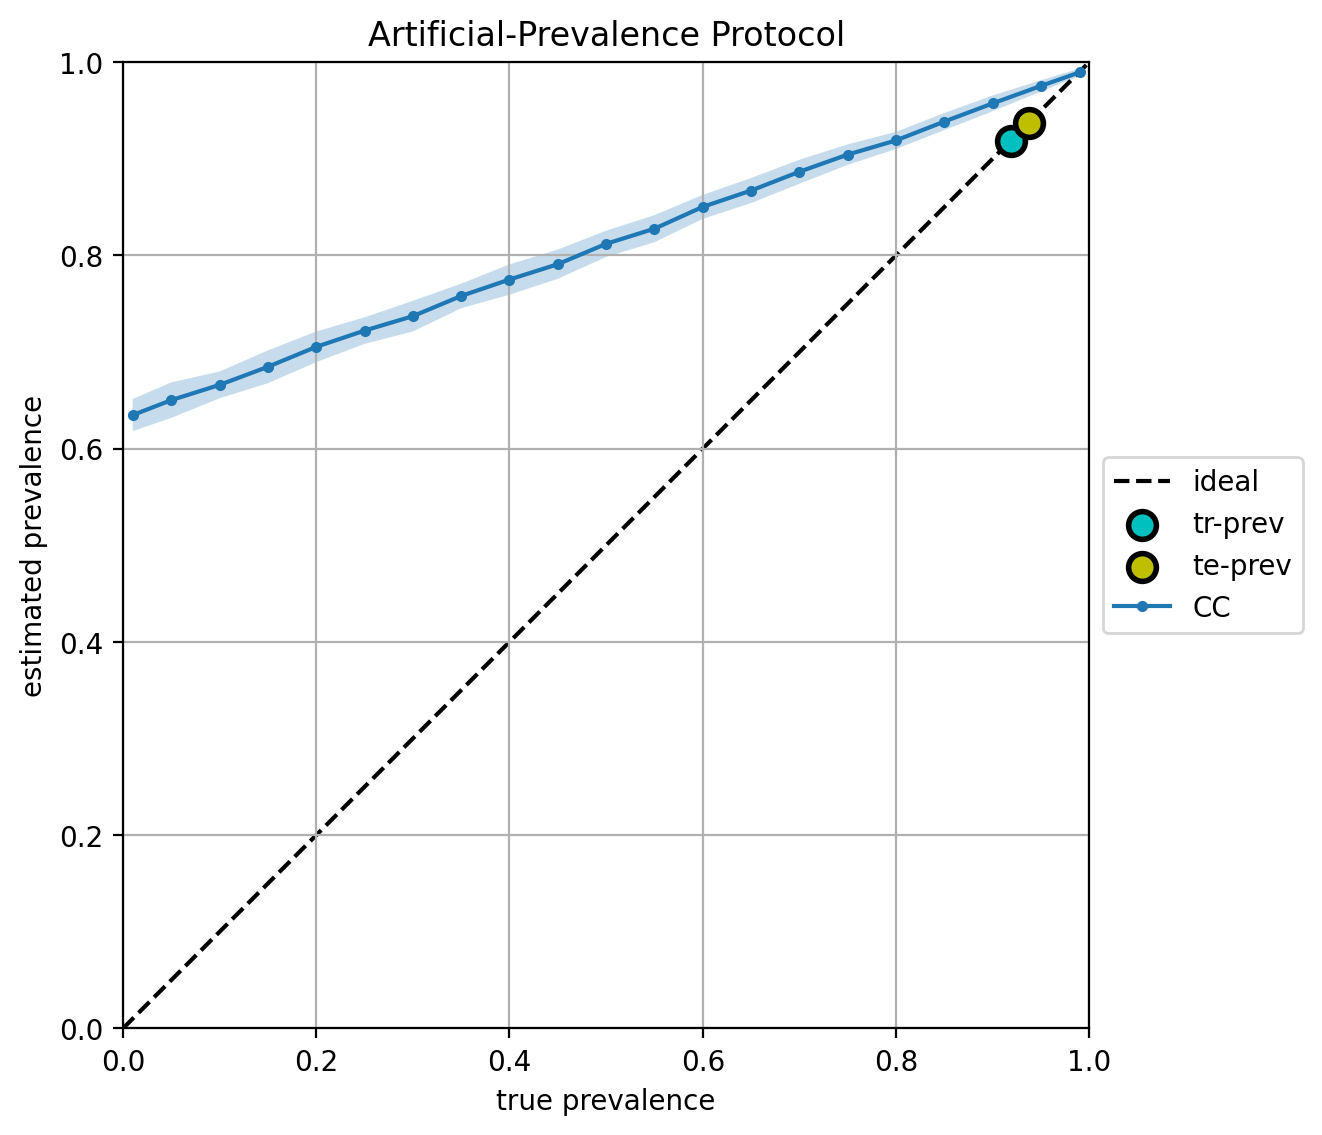

In [24]:
plot_corr(true_prevalences, {'CC':estim_prevalences}, train_prevalence, test_prevalence)

Note that CC produces large errors for low prevalences, but relatively small for prevalences close to that of the training collection. This behavior has been noticed in literature: 

_"CC is biased towards the training prevalence"_.

But maybe this behavior responds to the fact that we have _not_ optimized the SVM properly? 
Before moving on, however, we are going to define some convenient classes and methods:

In [25]:
from abc import ABCMeta, abstractmethod

# we could extend scikit-learn's Estimator class, but let's keep this 
# example simple
class BaseQuantifier(metaclass=ABCMeta): 
    """
    Abstract quantifier operating with document-by-term matrices
    """
    @abstractmethod
    def fit(self, data: LabelledCollection): ...

    @abstractmethod
    def predict(self, data, *args): ...

    def classify(self, data):
        return self.classifier.predict(data)

# let's rewrite our CC quantifier as a class    
class ClassifyAndCount(BaseQuantifier):
    def __init__(self, learner):
        self.learner = learner

    def fit(self, data : LabelledCollection):
        self.classifier = self.learner.fit(data.documents, data.labels)
        return self

    def predict(self, data, *args):
        return self.count(self.classify(data))

    def count(self, y):
        return y.mean()
    

# for convenience, we can define a method that, given a Quantifier and a test collection, computes
# all model's predictions for the artificial sampling protocol
def generate_predictions(method : BaseQuantifier, test : LabelledCollection, return_true_prevs=False):
    true_prevalences = []
    estim_prevalences = []

    for sample in tqdm(test.artificial_sampling_generator(SAMPLE_SIZE), total=2100, desc='testing'):
        true_prevalences.append(sample.prevalence())
        estim_prevalences.append(method.predict(sample.documents))

    true_prevalences = np.asarray(true_prevalences)
    estim_prevalences = np.asarray(estim_prevalences)
    
    if return_true_prevs:
        return true_prevalences, estim_prevalences 
    else:
        return estim_prevalences

    
# let us also define a function that, given a vector of true prevalences, and the predictions
# that different methods compute, compares them visually and numerically 
def evaluation_report(true_prevalences, by_method_predictions):
    plot_corr(true_prevalences, by_method_predictions, train_prevalence, test_prevalence)
    
    print('Evaluation Metrics (MAE):')
    for method_name, method_predictions in by_method_predictions.items():
        print(f'\tMAE({method_name})={100*MAE(true_prevalences, method_predictions):.3f}%')

Now, we will optimize the hyperparameter C of the SVMs responsible for the trade-off between marging and error. In classification, one typically does so via grid-search cross-validation. Here, we will simply plot quantification results for SVMs trained with different values of C, to see what happens:

<ipython-input-26-a1b386cc688f>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm(np.logspace(-3,3,7))


  0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-25-878f1fc1288c>:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm(test.artificial_sampling_generator(SAMPLE_SIZE), total=2100, desc='testing'):


testing:   0%|          | 0/2100 [00:00<?, ?it/s]

<ipython-input-25-878f1fc1288c>:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm(test.artificial_sampling_generator(SAMPLE_SIZE), total=2100, desc='testing'):


testing:   0%|          | 0/2100 [00:00<?, ?it/s]

<ipython-input-25-878f1fc1288c>:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm(test.artificial_sampling_generator(SAMPLE_SIZE), total=2100, desc='testing'):


testing:   0%|          | 0/2100 [00:00<?, ?it/s]

<ipython-input-25-878f1fc1288c>:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm(test.artificial_sampling_generator(SAMPLE_SIZE), total=2100, desc='testing'):


testing:   0%|          | 0/2100 [00:00<?, ?it/s]

<ipython-input-25-878f1fc1288c>:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm(test.artificial_sampling_generator(SAMPLE_SIZE), total=2100, desc='testing'):


testing:   0%|          | 0/2100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-25-878f1fc1288c>:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm(test.artificial_sampling_generator(SAMPLE_SIZE), total=2100, desc='testing'):


testing:   0%|          | 0/2100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
<ipython-input-25-878f1fc1288c>:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm(test.artificial_sampling_generator(SAMPLE_SIZE), total=2100, desc='testing'):


testing:   0%|          | 0/2100 [00:00<?, ?it/s]

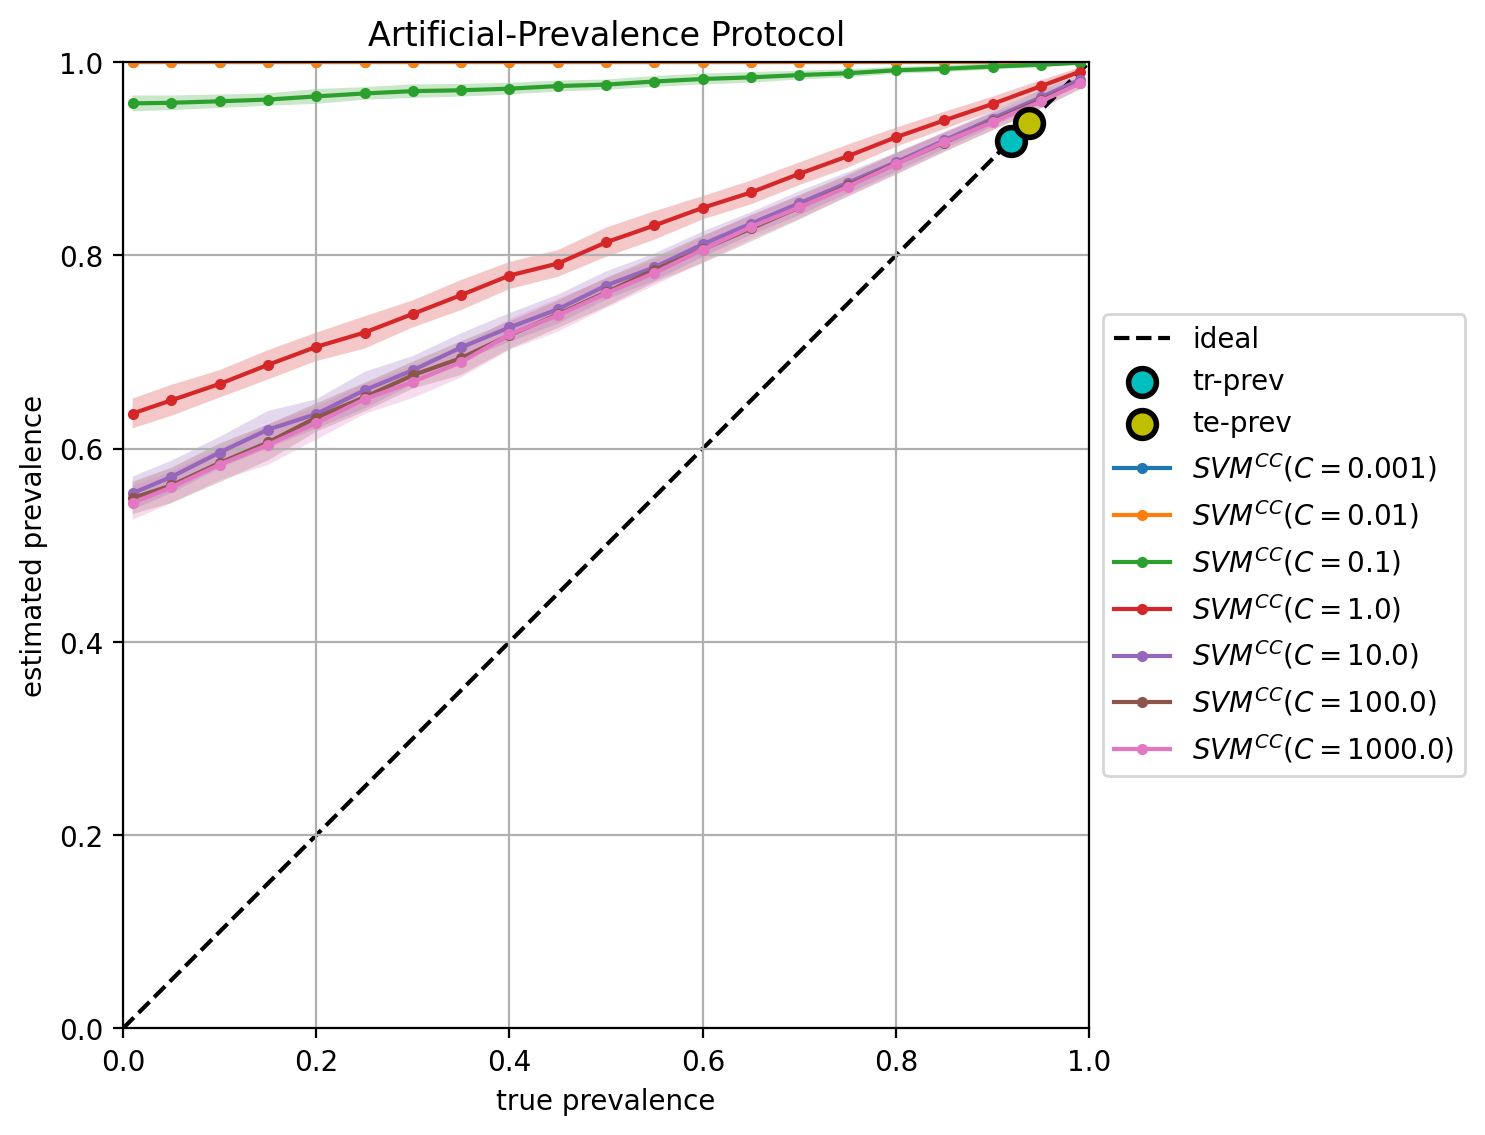

In [26]:
predictions = {}
pbar = tqdm(np.logspace(-3,3,7))
for C in pbar:
    pbar.set_description(f'optimizing hyperparameter C={C}')
    cc = ClassifyAndCount(LinearSVC(C=C)).fit(train)
    true_prevalences, estim_prevalences = generate_predictions(cc, test, return_true_prevs=True)
    predictions['$SVM^{CC}(C='+f'{C})$'] = estim_prevalences
    

plot_corr(true_prevalences, predictions, train_prevalence, test_prevalence)

At this point, it seems clear that the quantifier is "biased". We say an estimator to be biased whenever the expected value is produces tends to be deviated with respect to the true value. In other words, the errors it produces are not evenly distributed above or below the true value, but instead are more likely to be above, or to be below, the true value. In this case, we have observed how CC delivers biased quantification estimations, since *CC is biased towards the training prevalence*.

Let's do a quick experiment to see this more clearly. In this experiment we are going to vary the training prevalence on which each quantifier is trained.

<ipython-input-36-2589314d3809>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  pbar = tqdm([0.90, 0.75, 0.5, 0.25, 0.1])


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-25-878f1fc1288c>:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm(test.artificial_sampling_generator(SAMPLE_SIZE), total=2100, desc='testing'):


testing:   0%|          | 0/2100 [00:00<?, ?it/s]

<ipython-input-25-878f1fc1288c>:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm(test.artificial_sampling_generator(SAMPLE_SIZE), total=2100, desc='testing'):


testing:   0%|          | 0/2100 [00:00<?, ?it/s]

<ipython-input-25-878f1fc1288c>:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm(test.artificial_sampling_generator(SAMPLE_SIZE), total=2100, desc='testing'):


testing:   0%|          | 0/2100 [00:00<?, ?it/s]

<ipython-input-25-878f1fc1288c>:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm(test.artificial_sampling_generator(SAMPLE_SIZE), total=2100, desc='testing'):


testing:   0%|          | 0/2100 [00:00<?, ?it/s]

<ipython-input-25-878f1fc1288c>:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm(test.artificial_sampling_generator(SAMPLE_SIZE), total=2100, desc='testing'):


testing:   0%|          | 0/2100 [00:00<?, ?it/s]

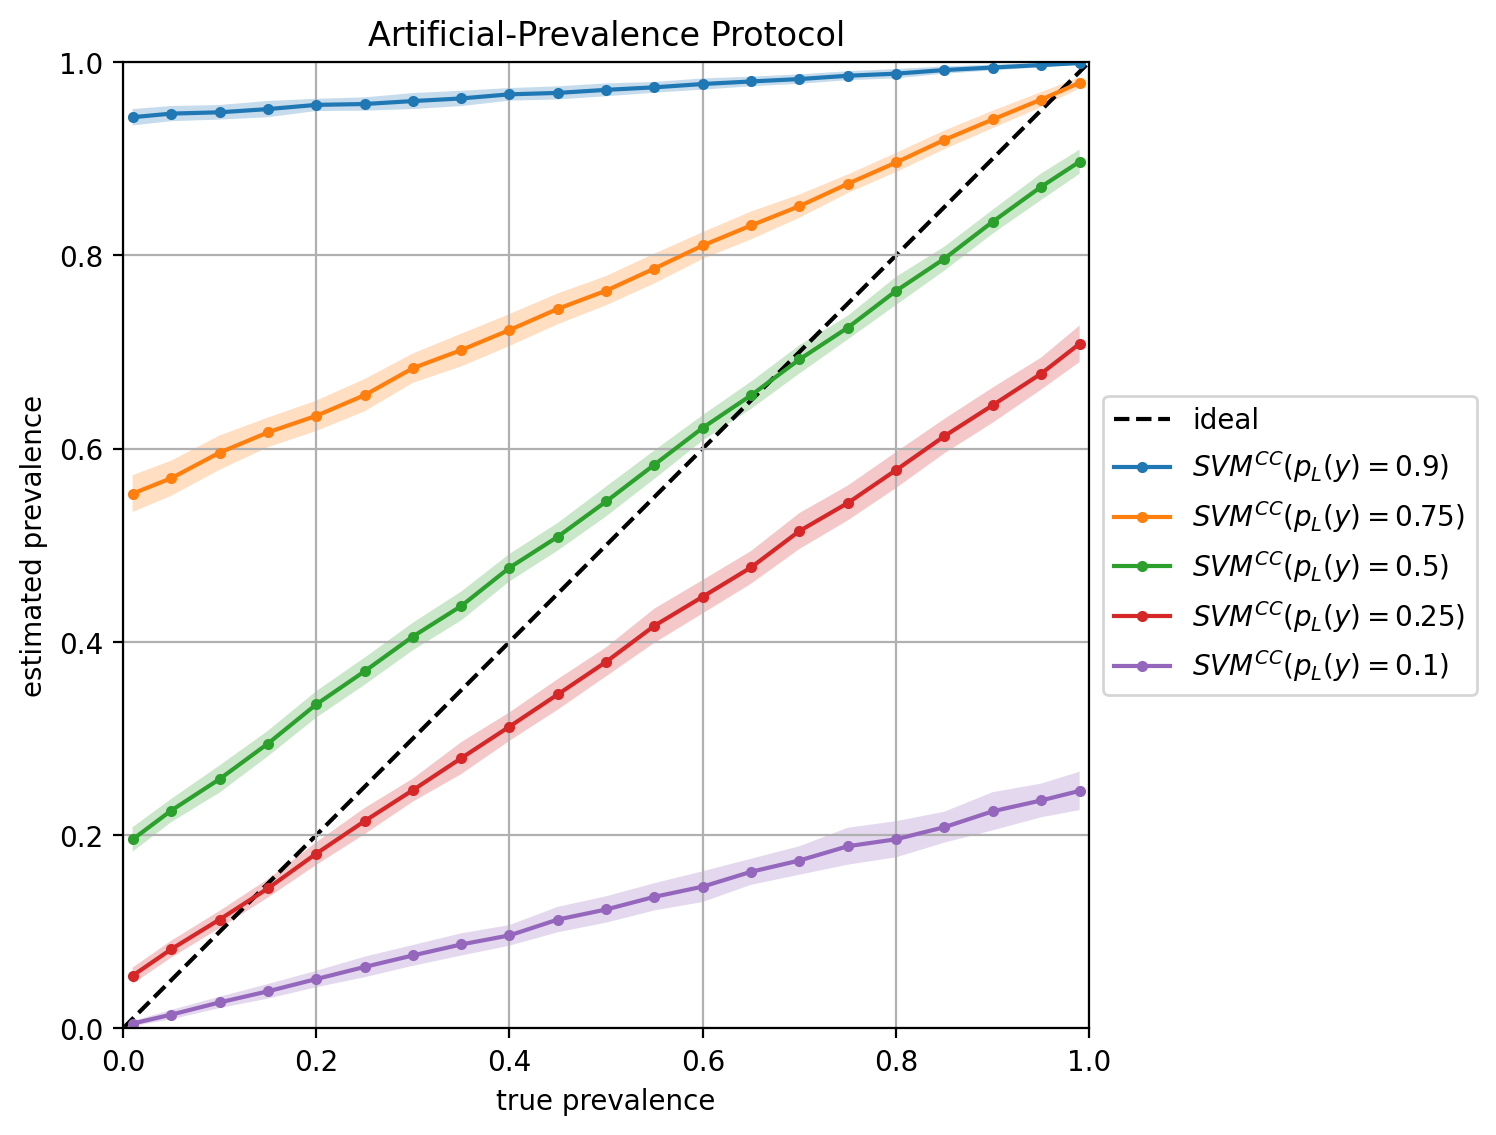

In [36]:
predictions = {}
pbar = tqdm([0.90, 0.75, 0.5, 0.25, 0.1])
for prev in pbar:
    pbar.set_description(f'changing the training prevalence prev={prev}')
    train_sample = train.sampling(prevalence=prev, size=500)
    cc = ClassifyAndCount(LinearSVC()).fit(train_sample)
    true_prevalences, estim_prevalences = generate_predictions(cc, test, return_true_prevs=True)
    predictions['$SVM^{CC}(p_L(y)='+f'{prev})$'] = estim_prevalences    

plot_corr(true_prevalences, predictions)

Note that the green line is not exactly centered in the (0.5, 0.5). This might be due to the fact that the training data contain fewer positives than the ones we are requesting; this means we have some duplicates in the training, which are not as informative as the negative examples.

# Exercise 3: Other Quantifiers
We have only used the CC approach so far, which is not a very good quantifier. We will implement some basic, but more sophisticated, quantifiers. 

We have pretty much a "framework" now. Let's do a brief recap using these new classes and methods:

<ipython-input-25-878f1fc1288c>:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm(test.artificial_sampling_generator(SAMPLE_SIZE), total=2100, desc='testing'):


testing:   0%|          | 0/2100 [00:00<?, ?it/s]

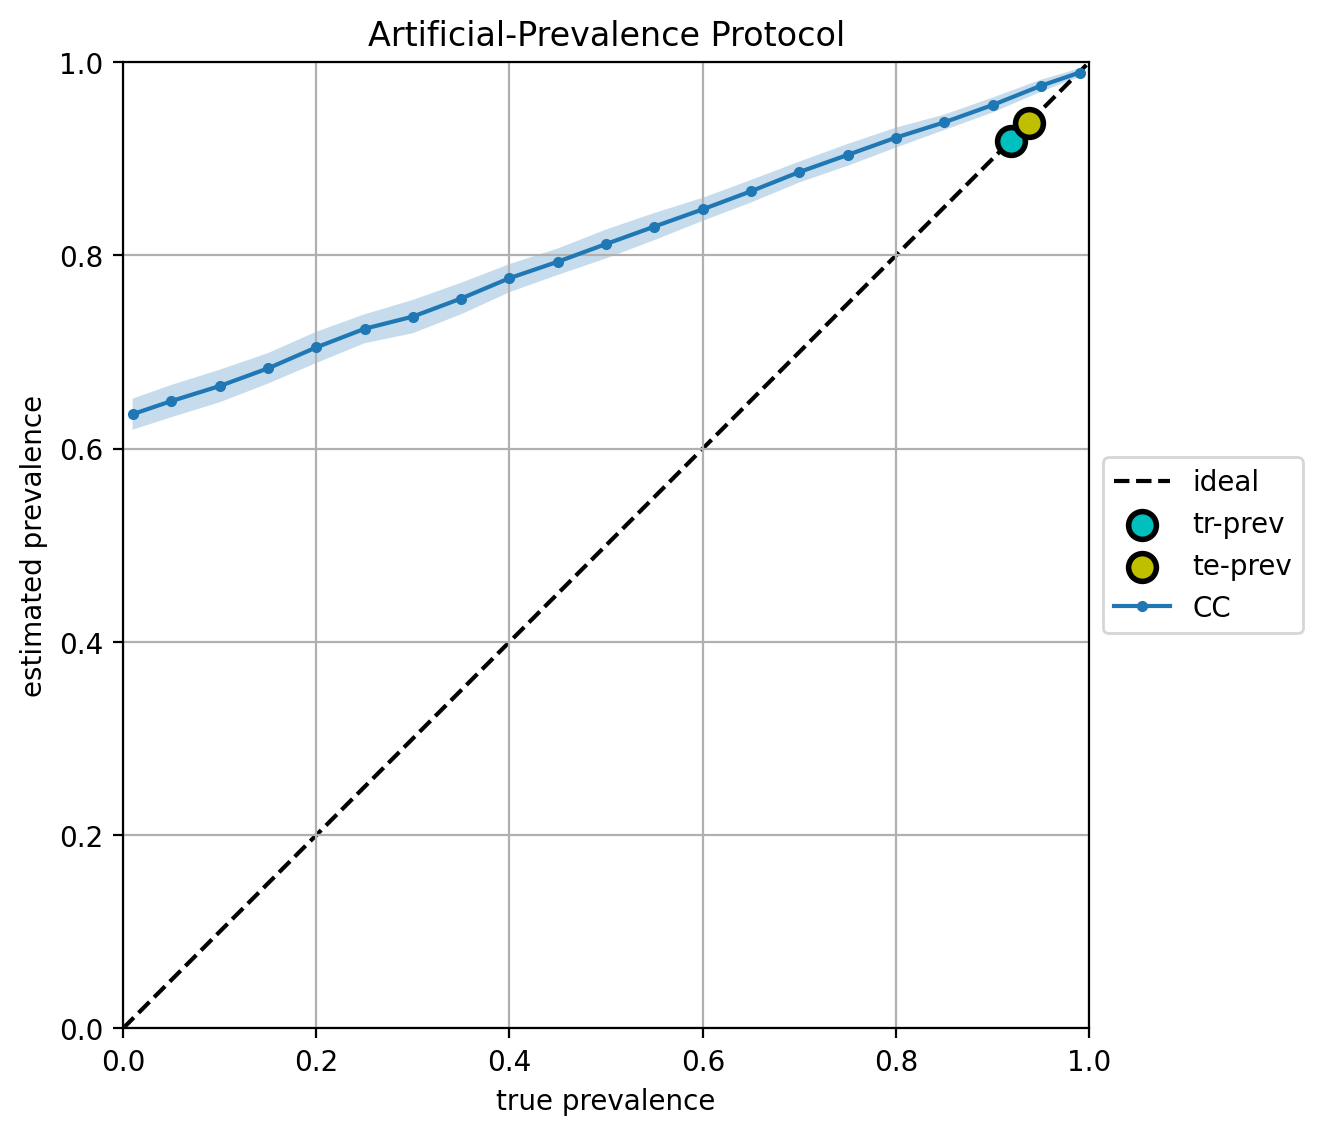

Evaluation Metrics (MAE):
	MAE(CC)=31.202%


In [37]:
cc = ClassifyAndCount(LinearSVC()).fit(train)
true_prevalences, estim_prevalences = generate_predictions(cc, test, return_true_prevs=True)
predictions = {'CC': estim_prevalences}
evaluation_report(true_prevalences, predictions)

## Adjusted Classify and Count (ACC)

How could we improve over the CC? Imagine we known that our classifier _tends_ to say "yes" more often than "no". Can we apply some "correction" or "adjustment" to the final prediction?
This is the idea behind Adjusted Classify and Count.

Actually, when performed via an aggregative method, Quantification is about characterizing the errors of the classifier and compensating for them.

Let us observe the 4-cell contingency table again:

In [38]:
show_4cell_contingencytable(tp, fp, fn, tn)

|             |    $y_+$    |    $y_-$    |
|-------------|:-----------:|:-----------:|
| $\hat{y}_+$ |  $tp$=20096 | $fp$=857 |
| $\hat{y}_-$ |  $fn$=138 | $tn$=500 |

Now, note that:

$\hat{p}=p \cdot(\frac{tp}{tp+fn}) + (1-p)\cdot(\frac{fp}{fp+tn}) = p \cdot tpr + (1-p)\cdot fpr$ 

And then, we can estimate:

$p = \frac{\hat{p}-fpr}{tpr-fpr}$

This corresponds to the "Adjusted" CC. However, note that the _tpr_ and _fpr_ are unknown. We have to estimate them using the training set exclusively. We can devote a fraction of the training data for that purpose:

In [39]:
def adjusted_quantification(estim, tpr, fpr, clip=True):
    den = tpr - fpr
    if den == 0:
        den += 1e-8
    adjusted = (estim - fpr) / den
    if clip:
        adjusted = np.clip(adjusted, 0, 1)
    return adjusted


def tpr(y_true, y_pred):
    return y_pred[y_true == 1].mean()


def fpr(y_true, y_pred):
    return y_pred[y_true == 0].mean()


class AdjustedClassifyAndCount(BaseQuantifier):
    def __init__(self, learner):
        self.cc = ClassifyAndCount(learner)

    def fit(self, data : LabelledCollection):
        train, val = data.split_stratified(train_size=0.6)
        self.cc.fit(train)
        val_predictions = self.cc.classify(val.documents)
        self.tpr_estim = tpr(val.labels, val_predictions)
        self.fpr_estim = fpr(val.labels, val_predictions)
        return self

    def predict(self, data, *args):
        cc = self.cc.predict(data)
        acc = adjusted_quantification(cc, self.tpr_estim, self.fpr_estim)
        return acc

    def classify(self, data):
        return self.cc.classify(data)

<ipython-input-25-878f1fc1288c>:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm(test.artificial_sampling_generator(SAMPLE_SIZE), total=2100, desc='testing'):


testing:   0%|          | 0/2100 [00:00<?, ?it/s]

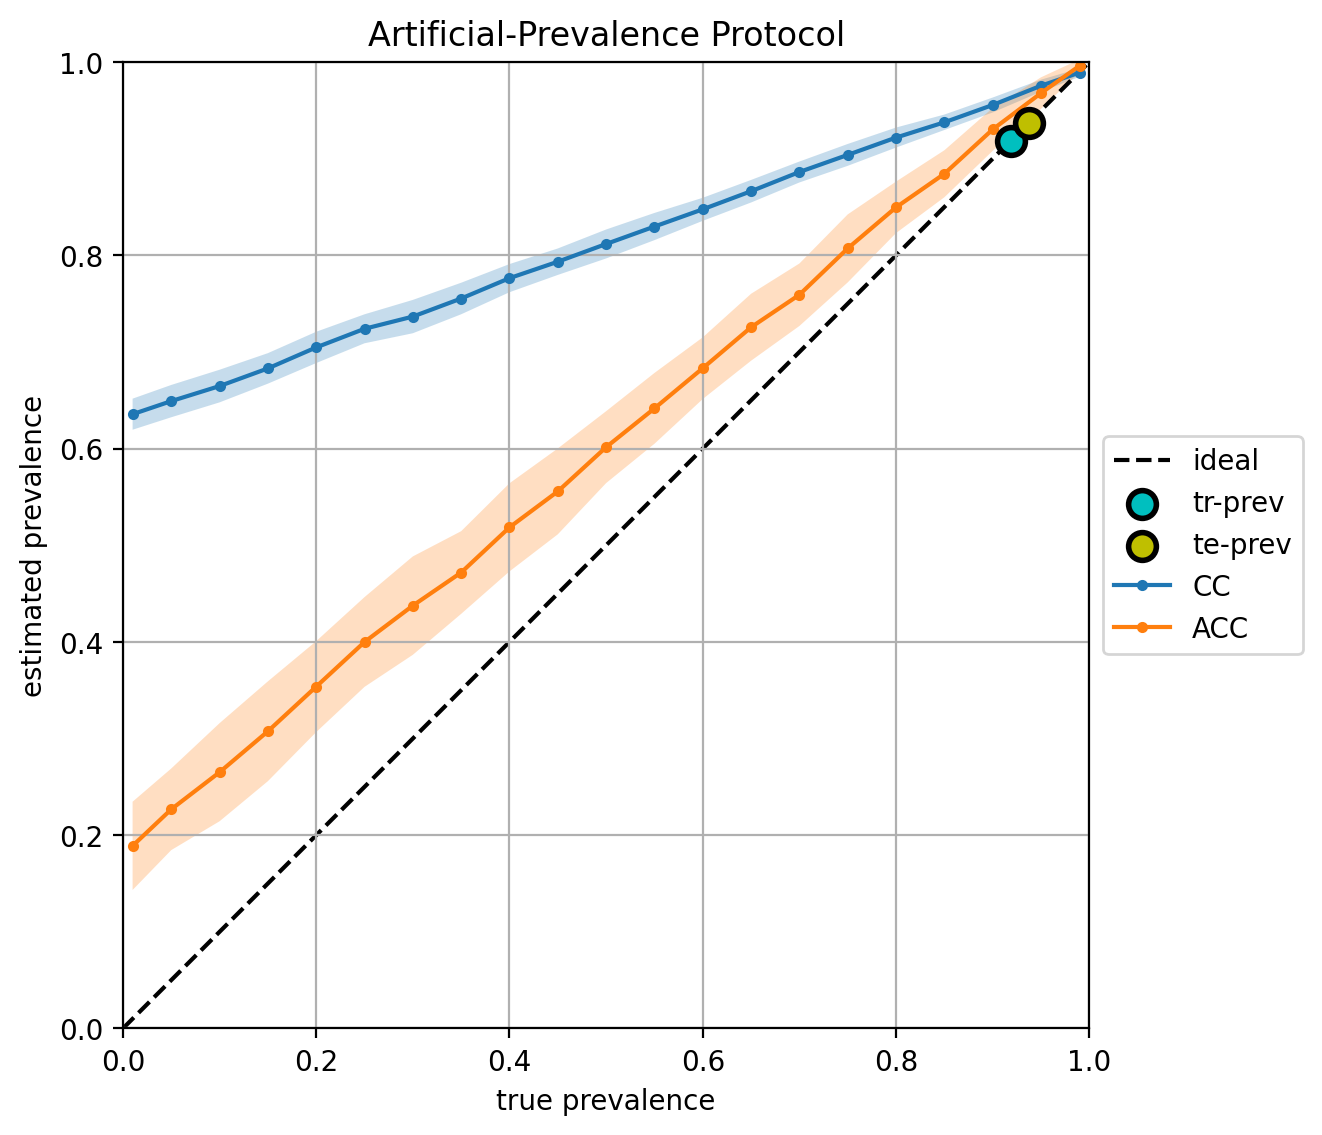

Evaluation Metrics (MAE):
	MAE(CC)=31.202%
	MAE(ACC)=9.941%


In [40]:
acc = AdjustedClassifyAndCount(LinearSVC()).fit(train)
predictions['ACC'] = generate_predictions(acc, test)
evaluation_report(true_prevalences, predictions)

## Probabilistic Classify and Count (PCC)

CC relies on counts of (hard) predictions. It would be preferable to employ a probabilistic classifier, i.e., one that computes the _posterior probability_ $Pr(y|x)$ instead of 1 or 0, so that we could take advantage of the "belief" of the classifier in that the example is positive or negative. 

Intuitively, imagine that a classifier outputs $Pr(y|x)=0.75$ for all items in a set. Since this value is above $0.5$, a CC would predict $100\%$ of positives. A probabilistic quantifier can use this information and guess a prevalence of $75\%$ since, for each item, it "thinks" the item is positive with $75\%$ probability.
This is the idea behind PCC.

The problem is that we need a probabilistic classifier, and SVMs are not. There are two main options here:
* Resort to a probabilistic classifier (e.g., Logistic Regression, Multinomial Naive Bayes, ...).
* _Calibrate_ our classifier (the one we will use here).

To calibrate a classifier means to map the _decision function_ of the classifier into the interval [0,1] so that the new outputs can be interpreted in terms of probability (e.g., the $\alpha\%$ of all items for which the classifier outputs $\alpha\%$ probability, are actually positive).

Among the many methods proposed in literature, we will use the _Platt Scalling_ (aka _sigmoid_) method.

In [41]:
from sklearn.calibration import CalibratedClassifierCV
class ProbabilisticClassifyAndCount(BaseQuantifier):
    def __init__(self, learner):
        self.learner = learner

    def fit(self, data : LabelledCollection):
        learner = self.learner
        if not hasattr(learner, 'predict_proba'):
            print(f'the learner {learner.__class__.__name__} does not seem to be probabilistic. '
                  'The learner will be calibrated.')
            learner = CalibratedClassifierCV(learner, cv=5)
        self.classifier = learner.fit(data.documents, data.labels)
        self.positive_class_index = np.argwhere(self.classifier.classes_== 1).item()
        return self

    def predict(self, data, *args):
        return np.clip(self.count(self.soft_classify(data)), 0, 1)

    def soft_classify(self, data):
        return self.classifier.predict_proba(data)[:, self.positive_class_index]

    def count(self, y):
        return y.mean()

the learner LinearSVC does not seem to be probabilistic. The learner will be calibrated.


<ipython-input-25-878f1fc1288c>:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm(test.artificial_sampling_generator(SAMPLE_SIZE), total=2100, desc='testing'):


testing:   0%|          | 0/2100 [00:00<?, ?it/s]

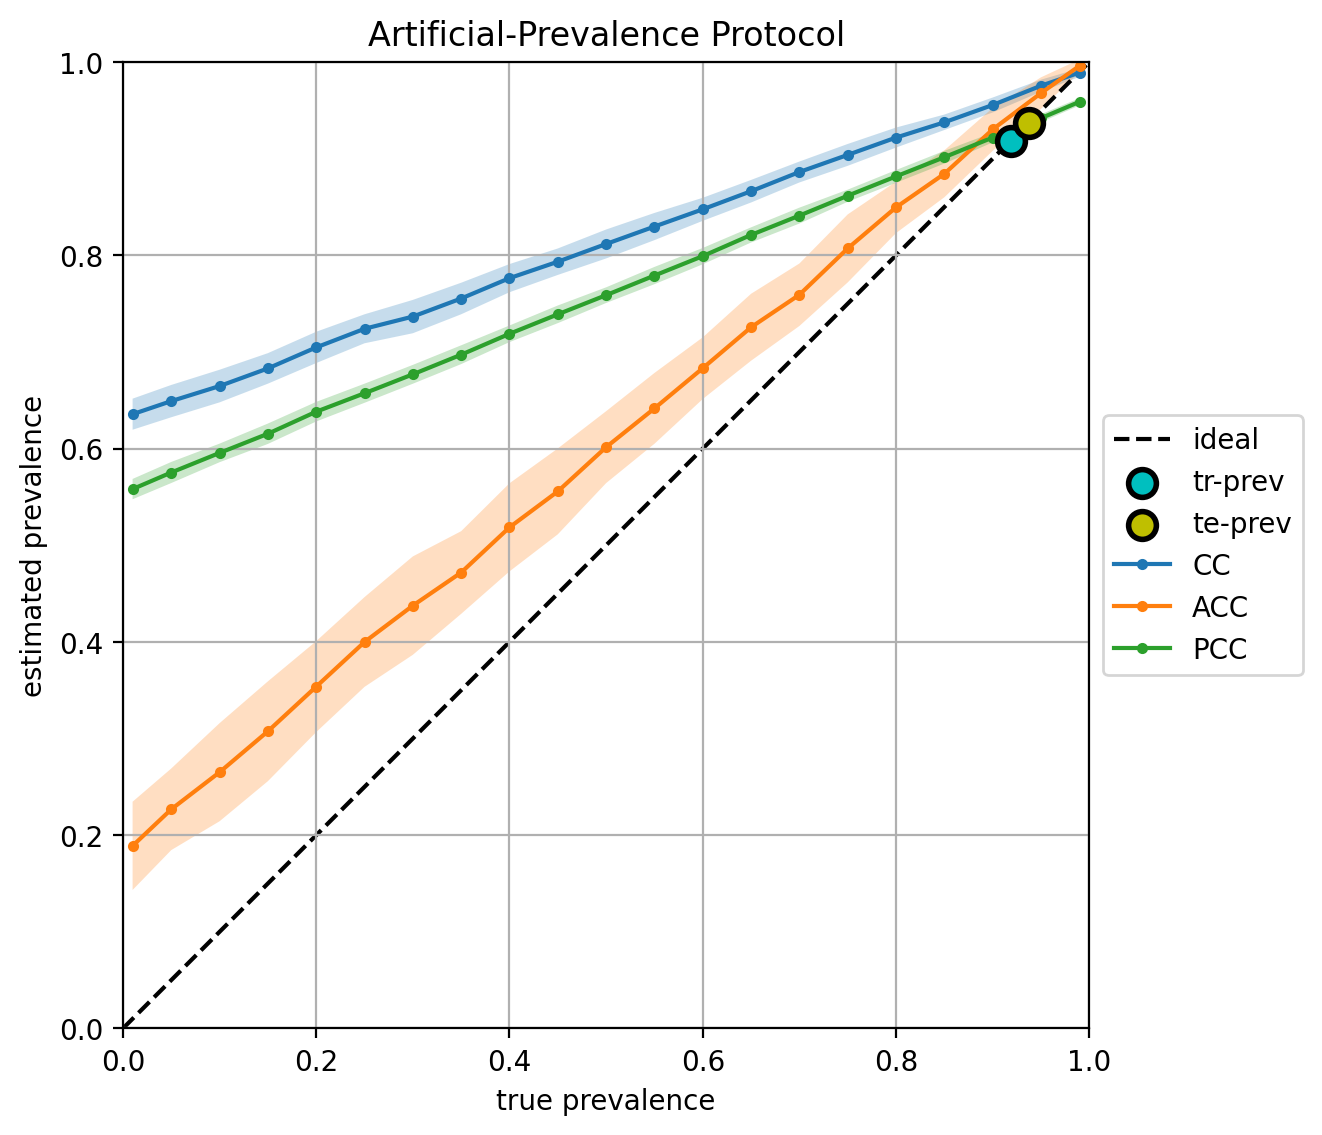

Evaluation Metrics (MAE):
	MAE(CC)=31.202%
	MAE(ACC)=9.941%
	MAE(PCC)=26.271%


In [42]:
pcc = ProbabilisticClassifyAndCount(LinearSVC()).fit(train)
predictions['PCC'] = generate_predictions(pcc, test)
evaluation_report(true_prevalences, predictions)

### Probabilistic Adjusted Classify and Count (PCC)

Of course, we can combine the rationales of ACC and PCC, and that would define the PACC method. 
The requirements thus are:
* To use a probabilistic classifier (or to calibrate it).
* To estimate _tpr_ and _fpr_ in a validation split.

In [43]:
class ProbabilisticAdjustedClassifyAndCount(BaseQuantifier):
    def __init__(self, learner):
        self.pcc = ProbabilisticClassifyAndCount(learner)

    def fit(self, data : LabelledCollection):
        train, val = data.split_stratified(train_size=0.6)
        self.pcc.fit(train)
        val_posteriors = self.pcc.soft_classify(val.documents)
        self.tpr_estim = tpr(val.labels, val_posteriors)
        self.fpr_estim = fpr(val.labels, val_posteriors)
        return self

    def predict(self, data, *args):
        pcc = self.pcc.predict(data)
        pacc = adjusted_quantification(pcc, self.tpr_estim, self.fpr_estim)
        return pacc

the learner LinearSVC does not seem to be probabilistic. The learner will be calibrated.


<ipython-input-25-878f1fc1288c>:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm(test.artificial_sampling_generator(SAMPLE_SIZE), total=2100, desc='testing'):


testing:   0%|          | 0/2100 [00:00<?, ?it/s]

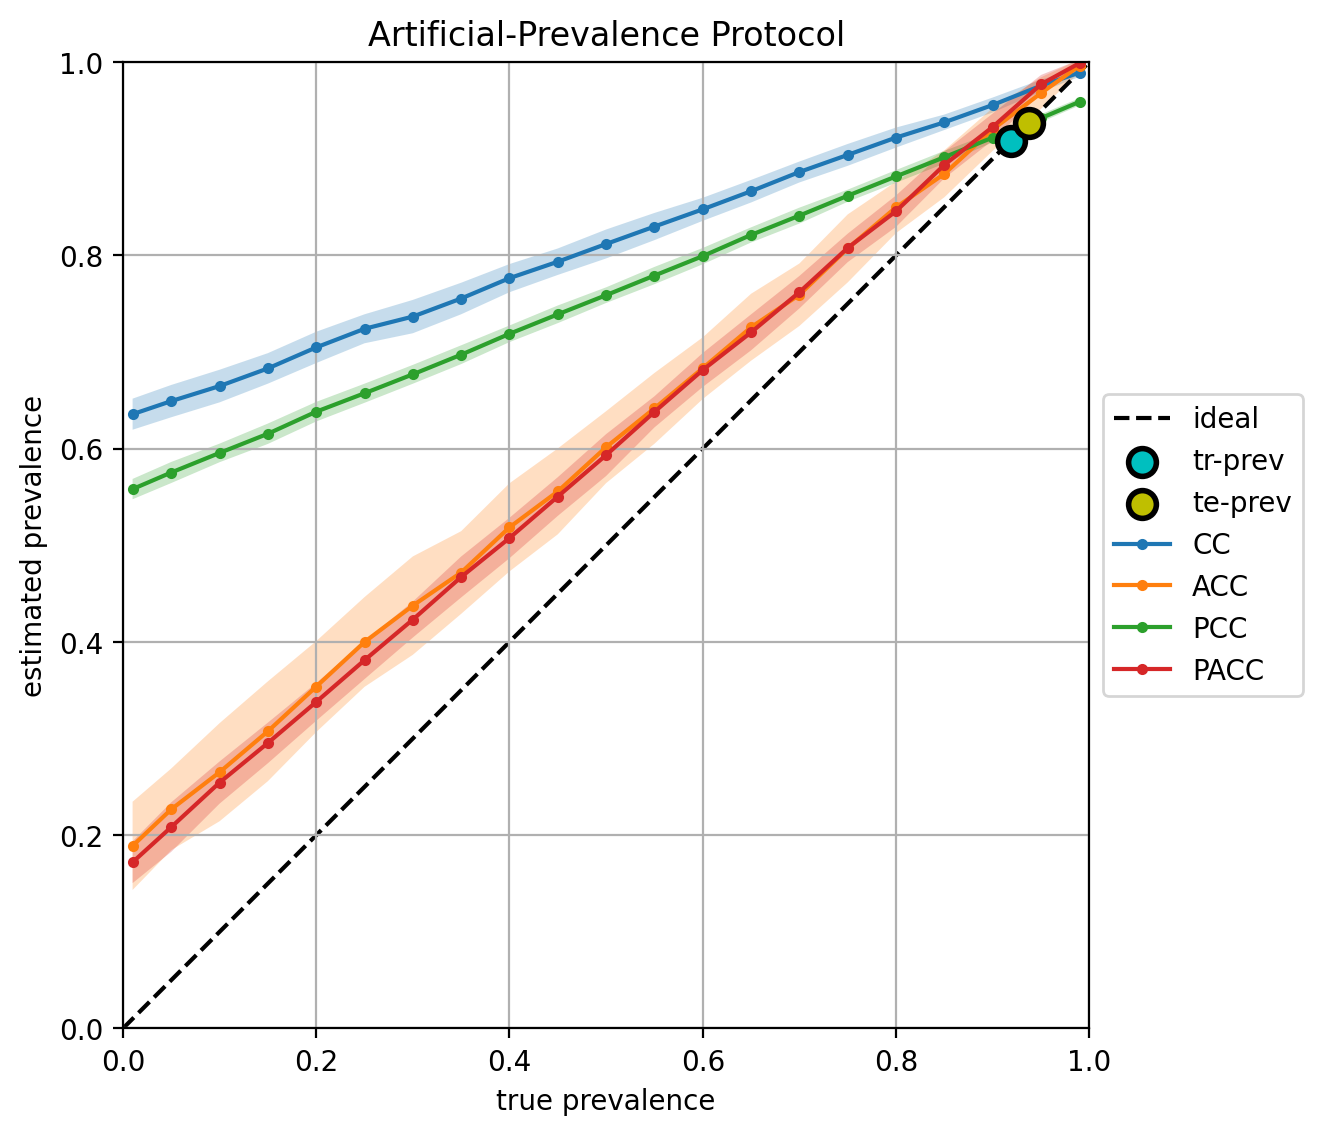

Evaluation Metrics (MAE):
	MAE(CC)=31.202%
	MAE(ACC)=9.941%
	MAE(PCC)=26.271%
	MAE(PACC)=9.279%


In [44]:
pacc = ProbabilisticAdjustedClassifyAndCount(LinearSVC()).fit(train)
predictions['PACC'] = generate_predictions(pacc, test)
evaluation_report(true_prevalences, predictions)

### Expectation-Maximization Quantification (EMQ)

CC, ACC, PCC, and PACC are simple methods for performing Quantification.
Of course, there exist many, more sophisticated methods, in literature.
One example, is the Expectation-Maximization Quantification (EMQ) method by Saerens.

I am not goint into the detail. At this point, it suffices to say that the 
method is an iterative process that iteratively shifts the prevalence estimations from the one in the training set in order to maximize the likelihood on the test data.

In [45]:
class EM_Quantifier(BaseQuantifier):
    def __init__(self, learner):
        self.learner = learner

    def fit(self, data : LabelledCollection):
        learner = self.learner
        if not hasattr(learner, 'predict_proba'):
            print(f'the learner {learner.__class__.__name__} does not seem to be probabilistic. '
                  'The learner will be calibrated.')
            learner = CalibratedClassifierCV(learner, cv=5)
        self.classifier = learner.fit(data.documents, data.labels)
        self.ytr = data.labels
        return self

    def predict(self, X, y=None, epsilon=1e-4):
        def prevalence(y, classname=1):
            return (y == classname).mean()

        Px = self.classifier.predict_proba(X)
        Px_pos = Px[:, self.classifier.classes_ == 1].flatten()
        Px_neg = Px[:, self.classifier.classes_ != 1].flatten()
        ytr = self.ytr
        trueprev = prevalence(y) if y is not None else -1

        Ptr_pos = prevalence(ytr, classname=1) #Ptr(y=+1)
        Ptr_neg = prevalence(ytr, classname=0) #Ptr(y=0)
        qs_pos, qs_neg = Ptr_pos, Ptr_neg   # i.e., prevalence(ytr)

        s, converged = 0, False
        qs_pos_prev_ = None
        while not converged and s < 500:
            # E-step: ps is Ps(y=+1|xi)
            pos_factor = (qs_pos / Ptr_pos) * Px_pos
            neg_factor = (qs_neg / Ptr_neg) * Px_neg
            ps = pos_factor / (pos_factor + neg_factor)

            # M-step: qs_pos is Ps+1(y=+1)
            qs_pos = np.mean(ps)
            qs_neg = 1 - qs_pos

            if qs_pos_prev_ is not None and abs(qs_pos - qs_pos_prev_) < epsilon and s>10:
                converged = True

            qs_pos_prev_ = qs_pos
            s += 1

        return qs_pos

the learner LinearSVC does not seem to be probabilistic. The learner will be calibrated.


<ipython-input-25-878f1fc1288c>:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm(test.artificial_sampling_generator(SAMPLE_SIZE), total=2100, desc='testing'):


testing:   0%|          | 0/2100 [00:00<?, ?it/s]

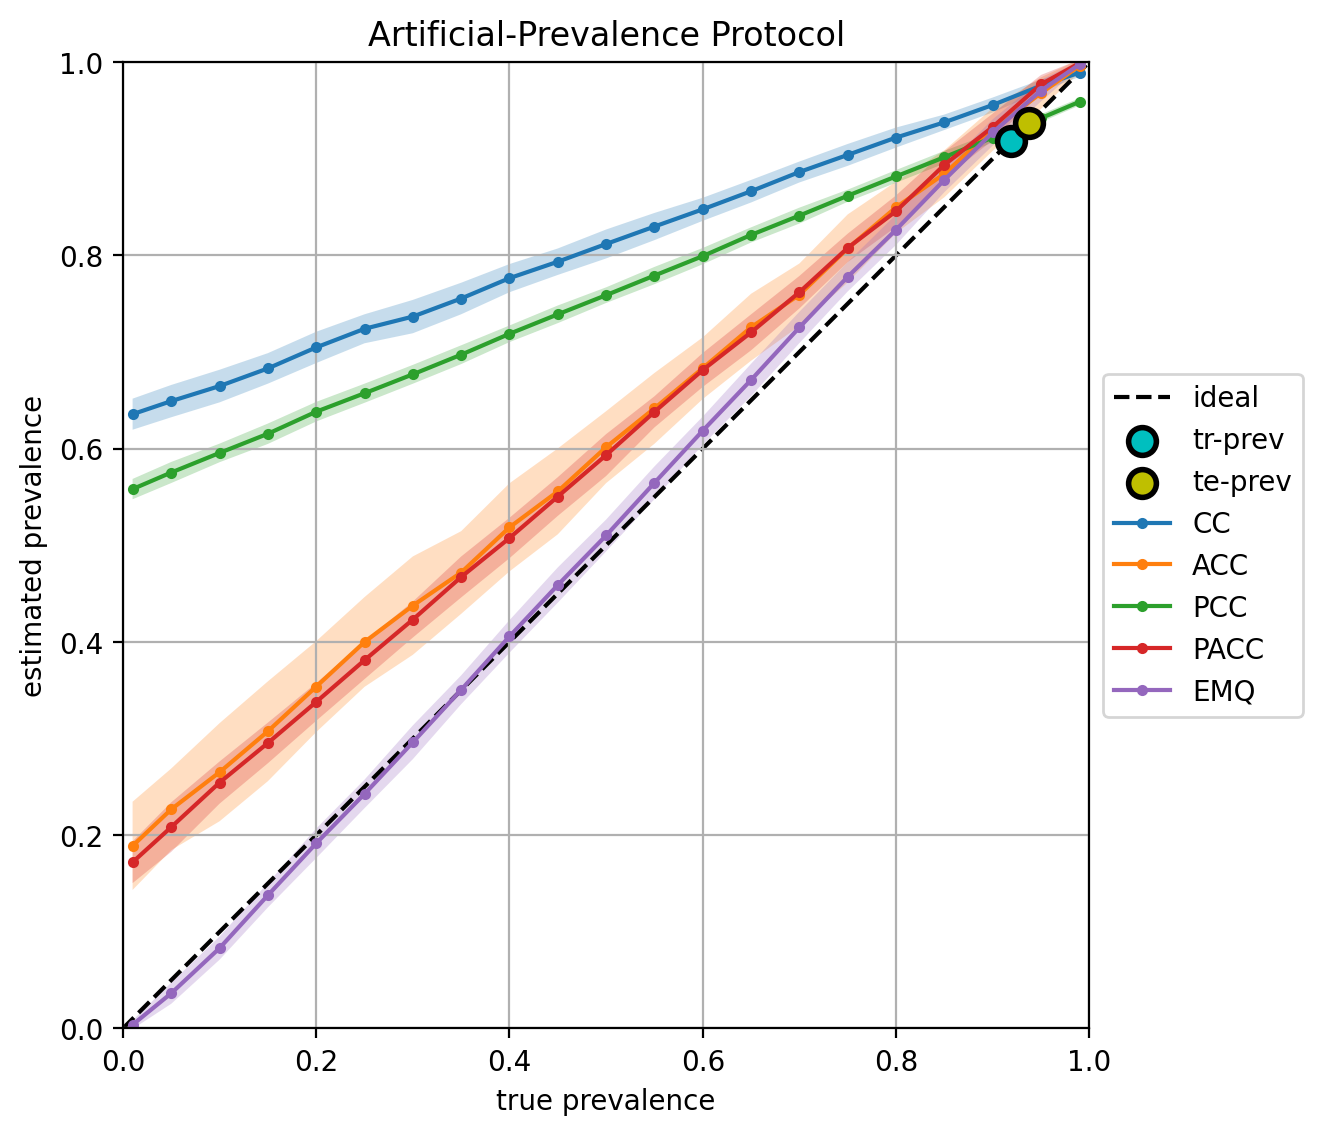

Evaluation Metrics (MAE):
	MAE(CC)=31.202%
	MAE(ACC)=9.941%
	MAE(PCC)=26.271%
	MAE(PACC)=9.279%
	MAE(EMQ)=1.818%


In [46]:
emq = EM_Quantifier(LinearSVC()).fit(train)
predictions['EMQ'] = generate_predictions(emq, test)
evaluation_report(true_prevalences, predictions)